In [ ]:
# 安裝必要套件 (Colab 環境)
!pip install faiss-cpu open_clip_torch scipy tqdm numpy pillow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 114.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.6 MB/s eta 0:00:00


# Stanford Cars Image Retrieval System

使用 CLIP + FAISS 的汽車圖片檢索系統

## 環境設定 (Colab + Kaggle)
1. 執行下方的 Kaggle API 設定 Cell
2. 上傳您的 `kaggle.json` 認證檔案
3. 自動下載並解壓縮 Stanford Cars Dataset

In [ ]:
# 設定 Kaggle API 並下載資料集
import os

# 方法1: 上傳 kaggle.json (推薦)
from google.colab import files
print("請上傳您的 kaggle.json 檔案")
print("(可從 https://www.kaggle.com/settings -> API -> Create New Token 取得)")
uploaded = files.upload()

# 設定 Kaggle 認證
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 0o600)

print("✅ Kaggle API 設定完成！")

請上傳您的 kaggle.json 檔案
(可從 https://www.kaggle.com/settings -> API -> Create New Token 取得)


Saving kaggle.json to kaggle.json
✅ Kaggle API 設定完成！


In [ ]:
# 下載 Stanford Cars Dataset 從 Kaggle
!pip install kaggle -q

# 下載資料集
!kaggle datasets download -d eduardo4jesus/stanford-cars-dataset -p /content/data --unzip

print("✅ 資料集下載完成！")

# 查看下載的內容
!ls -la /content/data/

Dataset URL: https://www.kaggle.com/datasets/eduardo4jesus/stanford-cars-dataset
License(s): unknown
 96% 1.75G/1.82G [00:03<00:00, 305MB/s]
100% 1.82G/1.82G [00:04<00:00, 490MB/s]
✅ 資料集下載完成！
total 20
drwxr-xr-x 5 root root 4096 Dec  3 05:09 .
drwxr-xr-x 1 root root 4096 Dec  3 05:09 ..
drwxr-xr-x 3 root root 4096 Dec  3 05:09 car_devkit
drwxr-xr-x 3 root root 4096 Dec  3 05:09 cars_test
drwxr-xr-x 3 root root 4096 Dec  3 05:09 cars_train


In [ ]:
import os
import numpy as np
import torch
import open_clip
from PIL import Image
from scipy.io import loadmat
from tqdm import tqdm
import faiss
import pickle

# 設定裝置
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"使用裝置: {device}")

使用裝置: cuda


In [ ]:
# 載入 CLIP 模型 (使用 OpenCLIP 的 ViT-B/32 較輕量)
model, _, preprocess = open_clip.create_model_and_transforms(
    'ViT-bigG-14',
    pretrained='laion2b_s39b_b160k'
)
model = model.to(device)
model.eval()

tokenizer = open_clip.get_tokenizer('ViT-bigG-14')

print("CLIP 模型載入完成！")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/10.2G [00:00<?, ?B/s]

CLIP 模型載入完成！


## 1. 載入資料集資訊
- 車款類別名稱 (cars_meta.mat)
- 訓練集標註 (cars_train_annos.mat)

In [ ]:
# 路徑設定 (Colab + Kaggle 環境)
BASE_PATH = "/content/data"

TRAIN_IMAGE_FOLDER = os.path.join(BASE_PATH, "cars_train", "cars_train")
TEST_IMAGE_FOLDER = os.path.join(BASE_PATH, "cars_test", "cars_test")
META_FILE = os.path.join(BASE_PATH, "car_devkit", "devkit", "cars_meta.mat")
TRAIN_ANNOS_FILE = os.path.join(BASE_PATH, "car_devkit", "devkit", "cars_train_annos.mat")
TEST_ANNOS_FILE = os.path.join(BASE_PATH, "car_devkit", "devkit", "cars_test_annos.mat")

# 驗證路徑
print(f"📁 Base Path: {BASE_PATH}")
print(f"📁 Train folder: {TRAIN_IMAGE_FOLDER}")
print(f"   存在: {os.path.exists(TRAIN_IMAGE_FOLDER)}")
print(f"📁 Meta file: {META_FILE}")
print(f"   存在: {os.path.exists(META_FILE)}")

📁 Base Path: /content/data
📁 Train folder: /content/data/cars_train/cars_train
   存在: True
📁 Meta file: /content/data/car_devkit/devkit/cars_meta.mat
   存在: True


In [ ]:
# 載入車款類別名稱
def load_car_classes(meta_path):
    """讀取 196 種車款名稱"""
    meta = loadmat(meta_path)
    class_names = meta['class_names'][0]
    classes = {}
    for i, name in enumerate(class_names):
        # 格式: "AM General Hummer SUV 2000"
        classes[i + 1] = name[0]  # class id 從 1 開始
    return classes

# 載入訓練集標註
def load_annotations(annos_path):
    """讀取標註資訊 (bbox, class, filename)"""
    annos = loadmat(annos_path)
    annotations = annos['annotations'][0]

    data = []
    for anno in annotations:
        bbox_x1 = anno['bbox_x1'][0][0]
        bbox_y1 = anno['bbox_y1'][0][0]
        bbox_x2 = anno['bbox_x2'][0][0]
        bbox_y2 = anno['bbox_y2'][0][0]
        class_id = anno['class'][0][0]
        fname = anno['fname'][0]

        data.append({
            'fname': fname,
            'class_id': class_id,
            'bbox': (bbox_x1, bbox_y1, bbox_x2, bbox_y2)
        })
    return data

# 載入資料
classes = load_car_classes(META_FILE)
train_annotations = load_annotations(TRAIN_ANNOS_FILE)

print(f"車款類別數量: {len(classes)}")
print(f"訓練集圖片數量: {len(train_annotations)}")
print(f"\n範例類別:")
for i in range(1, 6):
    print(f"  {i}: {classes[i]}")

車款類別數量: 196
訓練集圖片數量: 8144

範例類別:
  1: AM General Hummer SUV 2000
  2: Acura RL Sedan 2012
  3: Acura TL Sedan 2012
  4: Acura TL Type-S 2008
  5: Acura TSX Sedan 2012


In [ ]:
# 查看範例標註
print("範例標註:")
for i in range(5):
    anno = train_annotations[i]
    class_name = classes[anno['class_id']]
    print(f"  {anno['fname']}: {class_name}")

範例標註:
  00001.jpg: Audi TTS Coupe 2012
  00002.jpg: Acura TL Sedan 2012
  00003.jpg: Dodge Dakota Club Cab 2007
  00004.jpg: Hyundai Sonata Hybrid Sedan 2012
  00005.jpg: Ford F-450 Super Duty Crew Cab 2012


In [ ]:
# 生成豐富的文字描述
def generate_car_description(class_name):
    """
    根據車款名稱生成更豐富的描述
    例如: "AM General Hummer SUV 2000" -> 多條描述
    """
    descriptions = [
        f"a photo of a {class_name}",
        f"a {class_name} car",
        f"an image of {class_name}",
        f"{class_name} automobile",
        f"a picture showing {class_name}"
    ]

    # 解析車款資訊 (品牌 型號 類型 年份)
    parts = class_name.split()
    if len(parts) >= 2:
        # 嘗試提取年份 (通常在最後)
        if parts[-1].isdigit() and len(parts[-1]) == 4:
            year = parts[-1]
            car_type = parts[-2] if len(parts) > 2 else ""
            descriptions.append(f"a {year} model {car_type} car")
            descriptions.append(f"a {car_type} from {year}")

    return descriptions

# 測試
sample_class = classes[1]
print(f"類別: {sample_class}")
print(f"生成描述:")
for desc in generate_car_description(sample_class):
    print(f"  - {desc}")

類別: AM General Hummer SUV 2000
生成描述:
  - a photo of a AM General Hummer SUV 2000
  - a AM General Hummer SUV 2000 car
  - an image of AM General Hummer SUV 2000
  - AM General Hummer SUV 2000 automobile
  - a picture showing AM General Hummer SUV 2000
  - a 2000 model SUV car
  - a SUV from 2000


## 2. 產生 Image + Text Combined Embedding

結合策略：
- **Image Embedding**: CLIP encode_image
- **Text Embedding**: 對車款描述取平均 embedding
- **Combined Embedding**: α × Image + (1-α) × Text

In [ ]:
# 預先計算所有類別的文字 embedding
print("預先計算類別文字 embedding...")

class_text_embeddings = {}

for class_id, class_name in tqdm(classes.items(), desc="Processing classes"):
    descriptions = generate_car_description(class_name)

    # 編碼所有描述
    text_tokens = tokenizer(descriptions).to(device)
    with torch.no_grad():
        text_emb = model.encode_text(text_tokens)
        text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)
        # 取平均
        text_emb = text_emb.mean(dim=0, keepdim=True)
        text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)

    class_text_embeddings[class_id] = text_emb.cpu()

print(f"\n✅ 完成 {len(class_text_embeddings)} 個類別的文字 embedding")

預先計算類別文字 embedding...


Processing classes: 100%|██████████| 196/196 [00:42<00:00,  4.59it/s]


✅ 完成 196 個類別的文字 embedding


In [ ]:
# 產生所有圖片的 embedding
combined_embeddings = []
image_embeddings = []
text_embeddings = []
paths = []
class_ids_list = []
class_names_list = []

# 權重設定
ALPHA = 0.7  # image 權重，text 權重為 1-ALPHA

print(f"開始產生 embedding (α={ALPHA})...")
print(f"Combined = {ALPHA} × Image + {1-ALPHA} × Text\n")

for anno in tqdm(train_annotations, desc="Processing images"):
    fname = anno['fname']
    class_id = anno['class_id']
    class_name = classes[class_id]
    img_path = os.path.join(TRAIN_IMAGE_FOLDER, fname)

    if not os.path.exists(img_path):
        continue

    try:
        # 1. Image Embedding
        image = preprocess(Image.open(img_path).convert('RGB')).unsqueeze(0).to(device)
        with torch.no_grad():
            img_emb = model.encode_image(image)
            img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)

        # 2. Text Embedding (使用預先計算的類別 embedding)
        text_emb = class_text_embeddings[class_id].to(device)

        # 3. Combined Embedding
        combined = ALPHA * img_emb + (1 - ALPHA) * text_emb
        combined = combined / combined.norm(dim=-1, keepdim=True)

        # 儲存結果
        combined_embeddings.append(combined.cpu().numpy())
        image_embeddings.append(img_emb.cpu().numpy())
        text_embeddings.append(text_emb.cpu().numpy())
        paths.append(img_path)
        class_ids_list.append(class_id)
        class_names_list.append(class_name)

    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        continue

print(f"\n✅ 完成！共處理 {len(paths)} 張圖片")

開始產生 embedding (α=0.7)...
Combined = 0.7 × Image + 0.30000000000000004 × Text



Processing images: 100%|██████████| 8144/8144 [54:49<00:00,  2.48it/s]


✅ 完成！共處理 8144 張圖片


## 3. 建立 FAISS Index

In [ ]:
# 轉換為 numpy array
combined_array = np.vstack(combined_embeddings).astype("float32")
image_array = np.vstack(image_embeddings).astype("float32")
text_array = np.vstack(text_embeddings).astype("float32")

# 建立三種 Index
# 1. Combined Index (image + text)
index_combined = faiss.IndexFlatIP(combined_array.shape[1])
index_combined.add(combined_array)

# 2. Image-only Index
index_image = faiss.IndexFlatIP(image_array.shape[1])
index_image.add(image_array)

# 3. Text-only Index
index_text = faiss.IndexFlatIP(text_array.shape[1])
index_text.add(text_array)

print("✅ FAISS Index 建立完成！")
print(f"   Combined Index: {index_combined.ntotal} 向量")
print(f"   Image Index:    {index_image.ntotal} 向量")
print(f"   Text Index:     {index_text.ntotal} 向量")

✅ FAISS Index 建立完成！
   Combined Index: 8144 向量
   Image Index:    8144 向量
   Text Index:     8144 向量


## 4. 搜尋函數

In [ ]:
import json
from IPython.display import display

# 載入或建立 path.json
def load_path_mapping(path_json_file):
    """載入 path.json 檔案建立索引到路徑的對應"""
    with open(path_json_file, 'r', encoding='utf-8') as f:
        path_data = json.load(f)
    return path_data

def create_path_json(path_json_file, paths_list):
    """根據目前的 paths 列表建立 path.json"""
    with open(path_json_file, 'w', encoding='utf-8') as f:
        json.dump(paths_list, f, ensure_ascii=False, indent=2)
    print(f"✅ 已建立 {path_json_file}，共 {len(paths_list)} 筆路徑")

# 設定 path.json 路徑
PATH_JSON_FILE = os.path.join(BASE_PATH, "path.json")

# 載入或建立路徑對應
if os.path.exists(PATH_JSON_FILE):
    path_mapping = load_path_mapping(PATH_JSON_FILE)
    print(f"✅ 已載入 path.json，共 {len(path_mapping)} 筆路徑對應")
else:
    # 如果不存在，則根據目前的 paths 列表建立
    print(f"⚠️ 找不到 {PATH_JSON_FILE}，正在建立...")
    create_path_json(PATH_JSON_FILE, paths)
    path_mapping = paths  # 直接使用 paths 列表

def get_image_path(index):
    """根據索引取得圖片路徑，優先使用 path.json"""
    if path_mapping is not None:
        # 根據 path.json 的結構取得路徑
        # 如果是 list 格式
        if isinstance(path_mapping, list):
            return path_mapping[index]
        # 如果是 dict 格式 (key 是索引的字串)
        elif isinstance(path_mapping, dict):
            return path_mapping.get(str(index), paths[index])
    # fallback 到原本的 paths 列表
    return paths[index]

def search_by_text(query, k=5, index_type="combined"):
    """
    用文字搜尋圖片

    Args:
        query: 搜尋文字
        k: 返回結果數量
        index_type: "combined", "image", "text"
    """
    text = tokenizer([query]).to(device)
    with torch.no_grad():
        query_emb = model.encode_text(text)
        query_emb = query_emb / query_emb.norm(dim=-1, keepdim=True)
        query_emb = query_emb.cpu().numpy().astype("float32")

    # 選擇 index
    if index_type == "combined":
        index = index_combined
    elif index_type == "image":
        index = index_image
    else:
        index = index_text

    distances, indices = index.search(query_emb, k)

    results = []
    for j, i in enumerate(indices[0]):
        results.append({
            "path": get_image_path(i),
            "class_id": class_ids_list[i],
            "class_name": class_names_list[i],
            "score": distances[0][j]
        })
    return results


def search_by_image(img_path, k=5, index_type="combined"):
    """
    用圖片搜尋相似圖片

    Args:
        img_path: 圖片路徑
        k: 返回結果數量
        index_type: "combined", "image", "text"
    """
    image = preprocess(Image.open(img_path).convert('RGB')).unsqueeze(0).to(device)
    with torch.no_grad():
        query_emb = model.encode_image(image)
        query_emb = query_emb / query_emb.norm(dim=-1, keepdim=True)
        query_emb = query_emb.cpu().numpy().astype("float32")

    # 選擇 index
    if index_type == "combined":
        index = index_combined
    elif index_type == "image":
        index = index_image
    else:
        index = index_text

    distances, indices = index.search(query_emb, k)

    results = []
    for j, i in enumerate(indices[0]):
        results.append({
            "path": get_image_path(i),
            "class_id": class_ids_list[i],
            "class_name": class_names_list[i],
            "score": distances[0][j]
        })
    return results


def show_results(results, show_class=True):
    """顯示搜尋結果"""
    for i, r in enumerate(results):
        print(f"\n{'='*50}")
        print(f"[{i+1}] {r['class_name']} (Score: {r['score']:.4f})")
        if show_class:
            print(f"    📁 Class ID: {r['class_id']}")
        display(Image.open(r['path']).resize((300, 200)))

⚠️ 找不到 /content/data/path.json，正在建立...
✅ 已建立 /content/data/path.json，共 8144 筆路徑


## 5. 測試搜尋

🔍 搜尋: 'red sports car' (Combined Index)

[1] Chevrolet Corvette Convertible 2012 (Score: 0.5314)
    📁 Class ID: 55


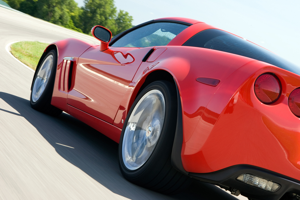


[2] Ferrari 458 Italia Coupe 2012 (Score: 0.5065)
    📁 Class ID: 104


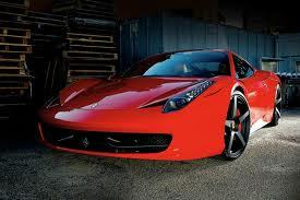


[3] Ferrari 458 Italia Coupe 2012 (Score: 0.5022)
    📁 Class ID: 104


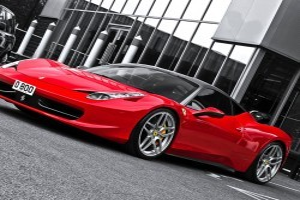


[4] Chevrolet Corvette ZR1 2012 (Score: 0.5015)
    📁 Class ID: 56


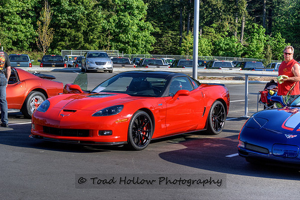


[5] Ferrari 458 Italia Coupe 2012 (Score: 0.4984)
    📁 Class ID: 104


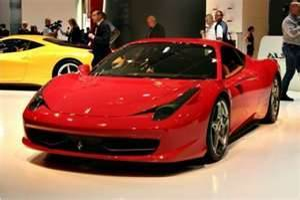

In [ ]:
# 文字搜尋測試 - 使用 Combined Index
print("🔍 搜尋: 'red sports car' (Combined Index)")
results = search_by_text("red sports car", k=5, index_type="combined")
show_results(results)

🔍 搜尋: 'SUV' (Combined Index)

[1] Land Rover LR2 SUV 2012 (Score: 0.5139)
    📁 Class ID: 155


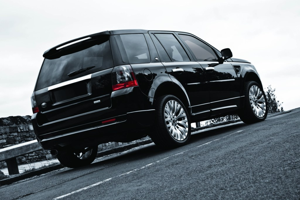


[2] Hyundai Santa Fe SUV 2012 (Score: 0.5135)
    📁 Class ID: 131


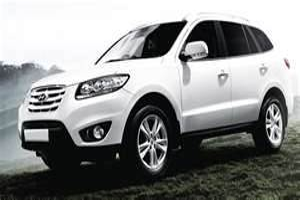


[3] Land Rover LR2 SUV 2012 (Score: 0.5105)
    📁 Class ID: 155


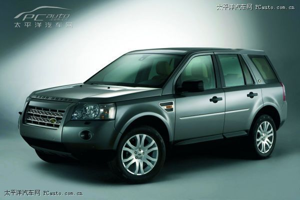


[4] Land Rover LR2 SUV 2012 (Score: 0.5102)
    📁 Class ID: 155


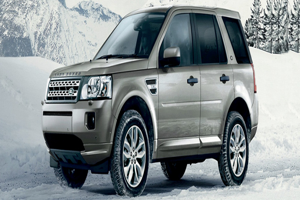


[5] Land Rover LR2 SUV 2012 (Score: 0.5085)
    📁 Class ID: 155


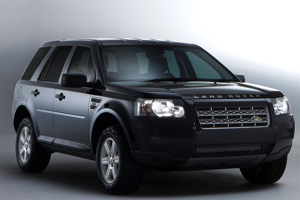

In [ ]:
# 文字搜尋測試 - SUV
print("🔍 搜尋: 'SUV' (Combined Index)")
results = search_by_text("SUV", k=5, index_type="combined")
show_results(results)

🔍 搜尋: 'BMW' (Combined Index)

[1] BMW M5 Sedan 2010 (Score: 0.5270)
    📁 Class ID: 35


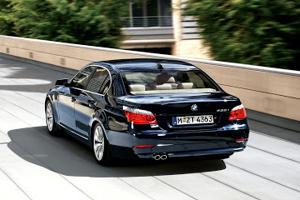


[2] BMW 3 Series Sedan 2012 (Score: 0.5231)
    📁 Class ID: 29


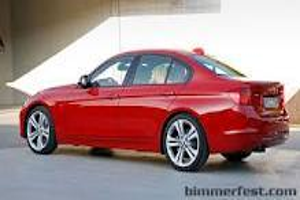


[3] BMW 3 Series Sedan 2012 (Score: 0.5161)
    📁 Class ID: 29


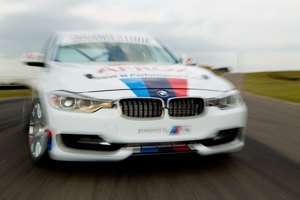


[4] BMW M3 Coupe 2012 (Score: 0.5143)
    📁 Class ID: 34


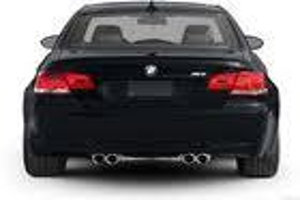


[5] BMW 3 Series Wagon 2012 (Score: 0.5120)
    📁 Class ID: 30


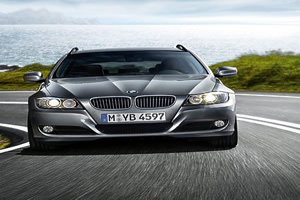

In [ ]:
# 文字搜尋測試 - 品牌
print("🔍 搜尋: 'BMW' (Combined Index)")
results = search_by_text("BMW", k=5, index_type="combined")
show_results(results)

In [ ]:
# 比較不同 Index 的搜尋結果
query = "convertible car"

print(f"🔍 搜尋: '{query}'\n")

print("=" * 60)
print("📊 Combined Index 結果:")
results_combined = search_by_text(query, k=5, index_type="combined")
for r in results_combined:
    print(f"  - {r['class_name']} (score: {r['score']:.4f})")

print("\n" + "=" * 60)
print("🖼️ Image-only Index 結果:")
results_image = search_by_text(query, k=5, index_type="image")
for r in results_image:
    print(f"  - {r['class_name']} (score: {r['score']:.4f})")

print("\n" + "=" * 60)
print("📝 Text-only Index 結果:")
results_text = search_by_text(query, k=5, index_type="text")
for r in results_text:
    print(f"  - {r['class_name']} (score: {r['score']:.4f})")

🔍 搜尋: 'convertible car'

📊 Combined Index 結果:
  - Ford Mustang Convertible 2007 (score: 0.5592)
  - Chevrolet Corvette Convertible 2012 (score: 0.5543)
  - Chevrolet Camaro Convertible 2012 (score: 0.5434)
  - Chevrolet Camaro Convertible 2012 (score: 0.5381)
  - Chevrolet Camaro Convertible 2012 (score: 0.5379)

🖼️ Image-only Index 結果:
  - Ford Mustang Convertible 2007 (score: 0.4277)
  - Geo Metro Convertible 1993 (score: 0.4183)
  - Geo Metro Convertible 1993 (score: 0.4133)
  - Geo Metro Convertible 1993 (score: 0.4114)
  - Audi RS 4 Convertible 2008 (score: 0.4051)

📝 Text-only Index 結果:
  - Chevrolet Camaro Convertible 2012 (score: 0.6709)
  - Chevrolet Camaro Convertible 2012 (score: 0.6709)
  - Chevrolet Camaro Convertible 2012 (score: 0.6709)
  - Chevrolet Camaro Convertible 2012 (score: 0.6709)
  - Chevrolet Camaro Convertible 2012 (score: 0.6709)


🖼️ 查詢圖片: Volvo C30 Hatchback 2012


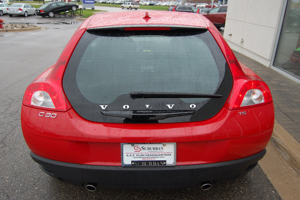


🔍 相似圖片 (Combined Index):

[1] Volvo C30 Hatchback 2012 (Score: 0.7021)
    📁 Class ID: 193


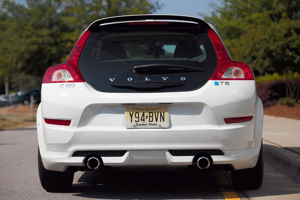


[2] Volvo C30 Hatchback 2012 (Score: 0.6659)
    📁 Class ID: 193


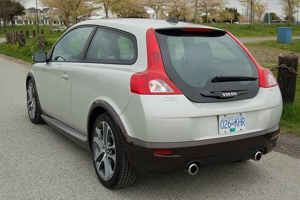


[3] Volvo C30 Hatchback 2012 (Score: 0.6507)
    📁 Class ID: 193


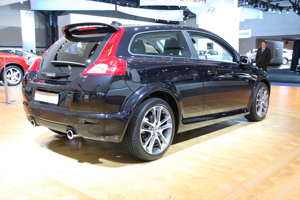


[4] Volvo C30 Hatchback 2012 (Score: 0.6444)
    📁 Class ID: 193


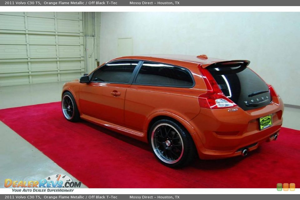


[5] Volvo C30 Hatchback 2012 (Score: 0.6413)
    📁 Class ID: 193


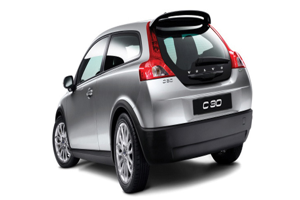

In [ ]:
# 圖片搜尋測試
sample_img = paths[100]  # 任選一張
print(f"🖼️ 查詢圖片: {class_names_list[100]}")
display(Image.open(sample_img).resize((300, 200)))

print("\n🔍 相似圖片 (Combined Index):")
results = search_by_image(sample_img, k=6, index_type="combined")  # k=6 因為第一個會是自己
show_results(results[1:])  # 跳過第一個（自己）

## 6. 儲存 Index 和資料

In [ ]:
# 儲存 FAISS Index
output_dir = os.path.join(BASE_PATH, "index")
os.makedirs(output_dir, exist_ok=True)

faiss.write_index(index_combined, os.path.join(output_dir, "cars_combined.index"))
faiss.write_index(index_image, os.path.join(output_dir, "cars_image.index"))
faiss.write_index(index_text, os.path.join(output_dir, "cars_text.index"))

# 儲存 metadata
metadata = {
    "paths": paths,
    "class_ids": class_ids_list,
    "class_names": class_names_list,
    "classes": classes,
    "alpha": ALPHA
}

with open(os.path.join(output_dir, "cars_metadata.pkl"), "wb") as f:
    pickle.dump(metadata, f)

print("✅ 已儲存:")
print(f"   - {os.path.join(output_dir, 'cars_combined.index')}")
print(f"   - {os.path.join(output_dir, 'cars_image.index')}")
print(f"   - {os.path.join(output_dir, 'cars_text.index')}")
print(f"   - {os.path.join(output_dir, 'cars_metadata.pkl')}")

✅ 已儲存:
   - /content/data/index/cars_combined.index
   - /content/data/index/cars_image.index
   - /content/data/index/cars_text.index
   - /content/data/index/cars_metadata.pkl


In [ ]:
# 載入已儲存的 Index (之後使用)
# 如果已經產生過 embedding，可以直接執行此 cell 載入

# import pickle
# import faiss
#
# BASE_PATH = "/content/data"
# output_dir = os.path.join(BASE_PATH, "index")
#
# # 載入 Index
# index_combined = faiss.read_index(os.path.join(output_dir, "cars_combined.index"))
# index_image = faiss.read_index(os.path.join(output_dir, "cars_image.index"))
# index_text = faiss.read_index(os.path.join(output_dir, "cars_text.index"))
#
# # 載入 metadata
# with open(os.path.join(output_dir, "cars_metadata.pkl"), "rb") as f:
#     metadata = pickle.load(f)
#     paths = metadata["paths"]
#     class_ids_list = metadata["class_ids"]
#     class_names_list = metadata["class_names"]
#     classes = metadata["classes"]
#
# print(f"✅ 載入完成！共 {index_combined.ntotal} 向量")

## 7. 進階功能: 依類別統計

In [ ]:
# 統計各類別的圖片數量
from collections import Counter

class_counts = Counter(class_names_list)
print("各類別圖片數量 (前20):")
for class_name, count in class_counts.most_common(20):
    print(f"  {class_name}: {count}")

各類別圖片數量 (前20):
  GMC Savana Van 2012: 68
  Chrysler 300 SRT-8 2010: 49
  Mitsubishi Lancer Sedan 2012: 48
  Mercedes-Benz 300-Class Convertible 1993: 48
  Jaguar XK XKR 2012: 47
  Chevrolet Corvette ZR1 2012: 47
  Volvo 240 Sedan 1993: 46
  Volkswagen Golf Hatchback 1991: 46
  Bentley Continental GT Coupe 2007: 46
  Audi S6 Sedan 2011: 46
  Ford GT Coupe 2006: 46
  Mercedes-Benz C-Class Sedan 2012: 46
  Nissan 240SX Coupe 1998: 46
  Suzuki Kizashi Sedan 2012: 46
  Eagle Talon Hatchback 1998: 46
  Dodge Durango SUV 2007: 46
  Geo Metro Convertible 1993: 45
  Chevrolet Malibu Sedan 2007: 45
  Jeep Grand Cherokee SUV 2012: 45
  Cadillac Escalade EXT Crew Cab 2007: 45


🔍 搜尋: '2012 model car' (Combined Index)

[1] Tesla Model S Sedan 2012 (Score: 0.5251)
    📁 Class ID: 185


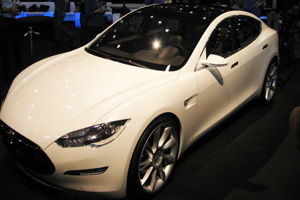


[2] smart fortwo Convertible 2012 (Score: 0.5226)
    📁 Class ID: 196


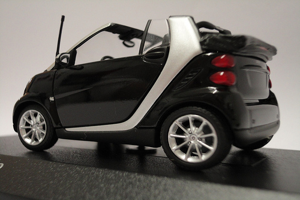


[3] Chevrolet Corvette Convertible 2012 (Score: 0.5171)
    📁 Class ID: 55


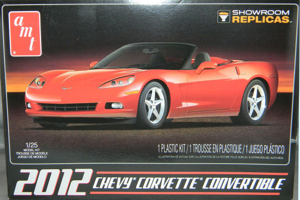


[4] Chevrolet Sonic Sedan 2012 (Score: 0.5162)
    📁 Class ID: 63


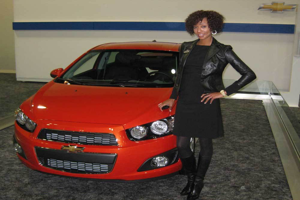


[5] Tesla Model S Sedan 2012 (Score: 0.5144)
    📁 Class ID: 185


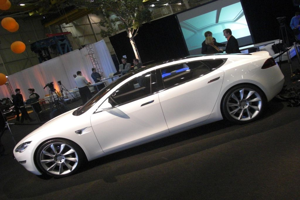

In [ ]:
# 搜尋特定年份的車
print("🔍 搜尋: '2012 model car' (Combined Index)")
results = search_by_text("2012 model car", k=5, index_type="combined")
show_results(results)